<a href="https://colab.research.google.com/github/LillyMac12/ACGWEP/blob/main/Inference_GW190412.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common emcee==2.2.1 --no-cache-dir

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 144.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 190.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 115.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 119.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 155.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 133.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW190412")

# List of observatories we'll analyze
ifos = ['H1',
        'L1',
       ]

# we'll keep track of the filename locations as we'll need them later
data_filenames = {}

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))

    # Download the gravitational wave data for GW170817
    url = "https://gwosc.org/eventapi/html/GWTC-2.1-confident/GW190412/v4/{}-{}1_GWOSC_4KHZ_R1-1239080215-4096.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True)
    data_filenames[ifo] = fname

    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:GWOSC-4KHZ_R1_STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate),
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd


/usr/local/lib/python3.11/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Processing H1 data
Processing L1 data


In [55]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy

static = {'mass1':17,
          'mass2':17,
          'f_lower':30.0,
          'approximant':"IMRPhenomXPHM",
          'polarization':0,
          'ra': 3.44615914,
          'dec': -0.40808407,
          'inclination': 1
         }

variable = ('distance',
            'tc')

inclination_prior = SinAngle(inclination=None)
distance_prior = Uniform(distance=(400, 1200))
tc_prior = Uniform(tc=(m.time-0.1, m.time+0.1))

prior = JointDistribution(
    variable, distance_prior, tc_prior)

In [56]:
import copy
model = models.SingleTemplate(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':30, 'L1':30},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )
smpl = sampler.EmceePTSampler(model, 5, 300, nprocesses=8)
_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

In [57]:
# Note it may take ~1-3 minutes for this to run
smpl.run_mcmc(400)

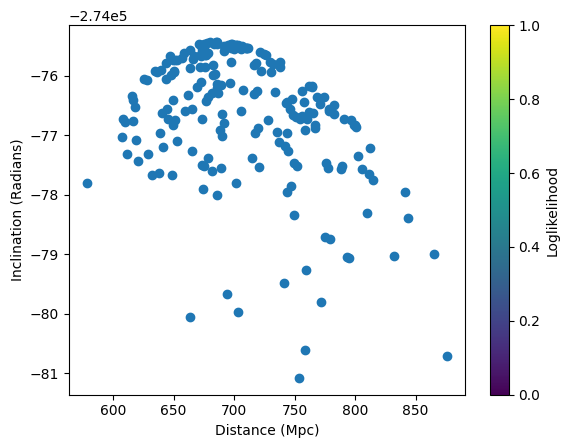

In [58]:
import pylab, numpy

lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Note how we have to access the arrays differently that before since there is an additional dimension.
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
#pylab.scatter(s['distance'][0,:,-1],
#              s['inclination'][0,:,-1],
#              c=lik[0,:,-1])
pylab.scatter(s['distance'][0,:,-1], lik[0,:,-1])
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

Text(0.5, 1.0, 'Distance Posterior GW190412')

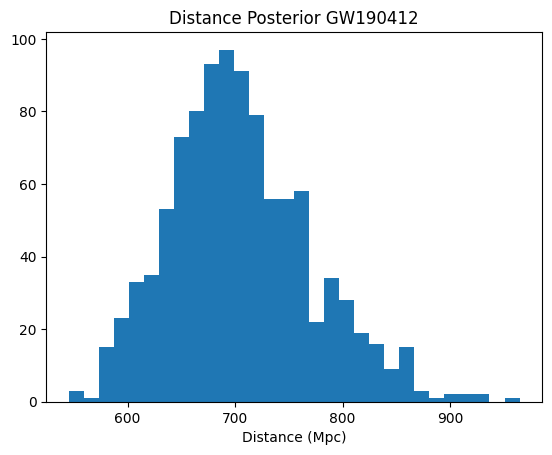

In [62]:
_ = pylab.hist(s['distance'][0,:,-100::20].flatten(), bins=30)
pylab.xlabel("Distance (Mpc)")
pylab.title("Distance Posterior GW190412")